* O seguinte projeto visa analisar dados sobre 100.000.000 de funcionários, com especial enfoque no salário. 
* O Pyspark será usado para analisar os dados e extrair informações úteis por meio de consultas SQL. 
* O Pyspark MLlib será usado para executar a engenharia de recursos e treinar o algoritmo Gradient Boosted Tree (GBT) para prever os salários dos empregadores.

# **Resumo dos principais resultados:**

Análise de dados:
- A indústria com maior receita é a de PETRÓLEO, a segunda é a de FINANÇAS e a terceira é a WEB.
- Para cada tipo de emprego, os trabalhadores com maior grau têm uma renda maior.
- O cargo mais bem pago é o de CEO, enquanto o menos pago é o de zelador.
- Para cada tipo de emprego, Engenharia, Negócios e Matemática são os cursos que levam a maiores rendimentos.
- O rendimento médio dos trabalhadores sem experiência difere muito entre os tipos de trabalho:
     - CEO tem uma renda base média em torno de 120k\\$, CFO em torno de 110k\\$ enquanto Zelador apenas 47k\\$.
- Entre todos os empregos, os salários médio, mediano e modal são respectivamente 116k\\$, 114k\\$ e 108k\\$. Eles não coincidem devido à assimetria correta da distribuição salarial.

Predição :
- Podemos ver que o algoritmo prevê melhores salários abaixo de 130k\\$, e começa a subestimar os salários acima de 175k\\$. Isso pode ser devido à assimetria correta da distribuição salarial.<br>
No geral, os resultados são satisfatórios em termos de RMSE e R2. Outras melhorias podem ser alcançadas por um ajuste adequado de hiperparâmetros e engenharia de recursos nos dados.

<img src="https://i.imgur.com/fBHkdi4.png" width="1000px">

In [1]:
!pip install pyspark

In [2]:
import os
for dirname, _, filenames in os.walk('/Data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import GBTRegressor

In [5]:
conf = SparkConf().set("spark.ui.showConsoleProgress", "false")
sc = SparkContext(appName="Pyspark, SQL and Machine Learning for salary prediction", conf=conf)
sc

23/01/14 17:38:21 WARN Utils: Your hostname, Ubuntu22Anaconda resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/01/14 17:38:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/14 17:38:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=Pyspark, SQL and Machine Learning for salary prediction>

In [6]:
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [10]:
path = 'Data/'
df_path = path + 'train_dataset.csv'
df1_path = path + 'train_salaries.csv'

# Carregamento do conjunto de dados e primeira análise

In [11]:
df1 = spark.read.csv(df_path, header=True).cache()

In [12]:
df2 = spark.read.csv(df1_path, header=True).cache()

In [13]:
df1.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [14]:
df2.show(5)

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows



Também podemos obter informações sobre os tipos de colunas:

In [15]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [16]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



Ao imprimir o esquema df, podemos ver que alguns recursos como salary, yearsExperience e milesFromMetropolis devem ser convertidos para o tipo inteiro!

In [17]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [18]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [19]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [20]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



Alteramos com sucesso o tipo de dados das três colunas mencionadas.

Antes de iniciar a análise, vamos juntar os dois dataframes no jobid. Se unirmos os dois dataframes como estão, teremos duas colunas idênticas jobId, o que criará ambiguidade. Por esse motivo, renomearemos a coluna JobId no segundo dataframe, para que possamos eliminá-la após a junção sem criar ambiguidade com a coluna jobId do primeiro dataframe.

In [21]:
df2 = df2.withColumnRenamed('jobId', 'job_id')

In [22]:
df = df1.join(df2, df1.jobId==df2.job_id)

In [23]:
df = df.drop('job_id')

In [24]:
df.show(5)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407695|   COMP20|       JANITOR|HIGH_SCHOOL|     NONE|EDUCATION|              1|                 54|    31|
|JOB1362684407696|   COMP41|VICE_PRESIDENT|  BACHELORS|CHEMISTRY|     AUTO|             17|                 68|   104|
+----------------+---------+--------------+-----

# Verificação de dados duplicados

In [25]:
df_dup=df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



Aparentemente não há linhas duplicadas!

# Verificação de valores ausentes

In [26]:
df.show(10)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407695|   COMP20|       JANITOR|HIGH_SCHOOL|     NONE|EDUCATION|              1|                 54|    31|
|JOB1362684407696|   COMP41|VICE_PRESIDENT|  BACHELORS|CHEMISTRY|     AUTO|             17|                 68|   104|
|JOB1362684407700|   COMP54|        JUNIOR|    M

Podemos ver que algumas colunas têm valores 'NONE', esses valores estão faltando?

In [28]:
print('Numero de valores ausentes para jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Numero de valores ausentes para degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Numero de valores ausentes para major: {}'.format(df.filter(df.major=='NONE').count()))
print('Numero de valores ausentes para industry: {}'.format(df.filter(df.industry=='NONE').count()))

Numero de valores ausentes para jobType: 0
Numero de valores ausentes para degree: 236854
Numero de valores ausentes para major: 532355
Numero de valores ausentes para industry: 0


Na verdade, eles não estão faltando valores! Indicam que o trabalhador não possui graduação ou especialização, por exemplo. Não vamos dropar esses valores.

# Dataset Analayis

Podemos obter algumas informações básicas sobre as colunas numéricas chamando o método describe

In [29]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885673| 28.877732628720036|38.71793638113296|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



O salário mínimo parece ser 0, isso está relacionado a trabalhos de voluntariado? Isso será investigado mais tarde!

# Q1 Qual é o trabalho mais bem pago?

Para realizar consultas SQL no dataset, devemos criar uma tabela com base no dataframe do spark, conforme a seguir:

In [30]:
df.createOrReplaceTempView("data")

Então podemos realizar consultas SQL!

In [31]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



**Os cargos mais bem pagos são CFO (Chief Financial Officer) e CTO (Chief Technology Officer) na indústria OIL, com um salário de 301k$.**

# Q2 Which are the TOP 20 jobs in terms of highest salary?

In [77]:
df_q2 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO|     OIL|   4|
|   294|    CEO| FINANCE|   1|
|   293|    CEO|     OIL|   5|
|   293|    CEO| FINANCE|   2|
|   292|    CEO| FINANCE|   3|
|   292|    CTO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CTO|     WEB|   2|
|   289|    CFO|     OIL|   6|
|   289|    CEO| FINANCE|   5|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+



**We can find the previous result (obtained with a subquery) of the highest paid jobs, in particular we can see that 8 of the TOP20 paid jobs are in the OIL industry(5 of them in the TOP10), 10  are from FINANCE and 2 are from WEB. We also added a Rank column to improve the readability of the result.**

# Q3 Qual é o trabalho menos pago?

In [32]:
spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|           CTO|     AUTO|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|       MANAGER|  FINANCE|   1|
|     0|        JUNIOR|      OIL|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



Podemos ver claramente que os empregos com salário 0\\$ provavelmente estão com valores faltantes, pois estão relacionados, por exemplo, às indústrias OIL e WEB, que são muito bem remuneradas (como visto anteriormente). Além disso, também existe o cargo de 'vice-presidente', que é impossível ter 0$ de salário. Vamos descartar essas linhas. <br>


In [33]:
df = df.where("salary != 0")

Em seguida, também precisamos recarregar a tabela, pois atualizamos o dataframe df.

In [34]:
df.createOrReplaceTempView("data")

In [35]:
df_q3 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''')
df_q3.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
+------+-------+---------+----+
only showing top 20 rows



**Podemos ver que agora o trabalho com menor remuneração é 'zelador', com um salário mínimo de 17k$.**

# Q4 Quais são as 3 principais indústrias em termos de salário mais alto?

In [36]:
df_q4 = spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(10)

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



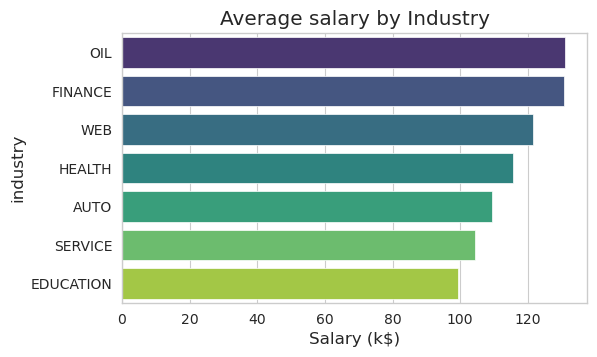

In [37]:
df_p = df_q4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

**Podemos ver que as duas primeiras indústrias são OIL e FINANCE, com um salário médio muito semelhante de 130k\\$. A terceira indústria com maior salário é a WEB. Poderíamos esperar esse resultado observando o resultado da consulta do primeiro trimestre.**

# Q5 Os trabalhadores com mais anos de experiência recebem mais?

In [38]:
df_q5 = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''') 
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CTO|     OIL|             24|
|   301|    CFO|     OIL|             23|
|   298|    CEO|     OIL|             22|
|   294|    CEO|     OIL|             19|
|   294|    CEO| FINANCE|             24|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CTO| FINANCE|             24|
|   292|    CEO| FINANCE|             22|
|   290|    CEO|     WEB|             20|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   289|    CEO| FINANCE|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO|     OIL|             22|
|   287|    CEO| FINANCE|             19|
|   286|    CEO| FINANCE|             24|
|   286|    CTO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

Para melhorar a legibilidade dos resultados, traçaremos o salário X tipo de trabalho. Antes de fazer isso, devemos verificar os diferentes tipos de trabalho no dataframe:

In [39]:
df_q5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [40]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

Em seguida, precisamos converter o dataframe extraído pela consulta SQL Q5 em um dataframe do pandas:

In [41]:
df_p = df_q5.toPandas()

Finalmente, podemos criar os gráficos com um loop for, incluindo uma regressão linear para melhorar a legibilidade dos gráficos.

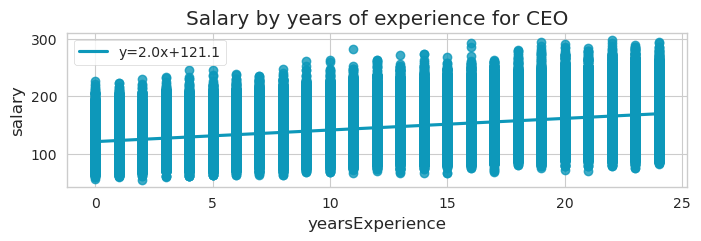

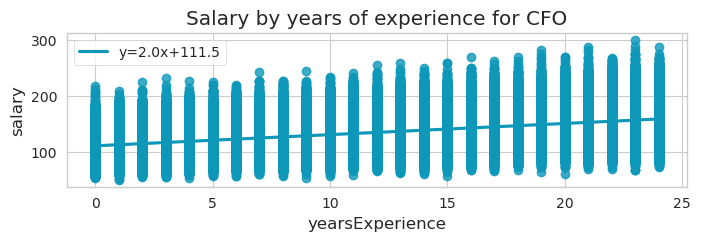

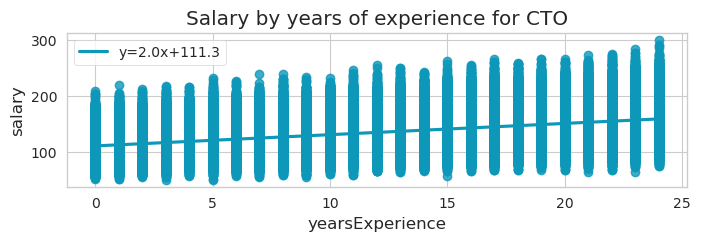

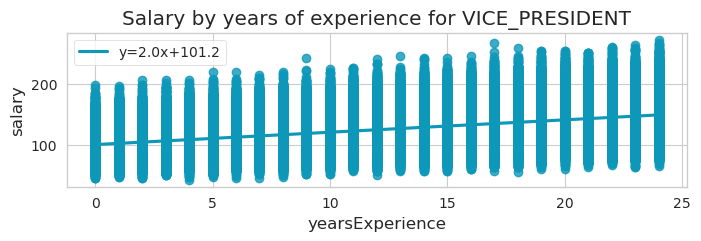

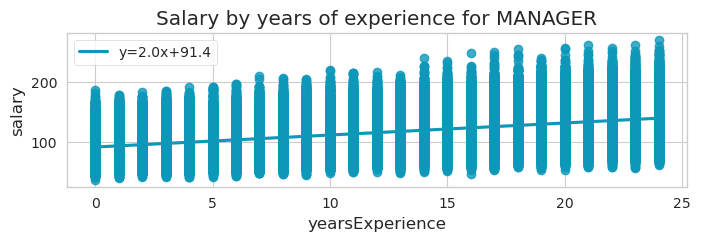

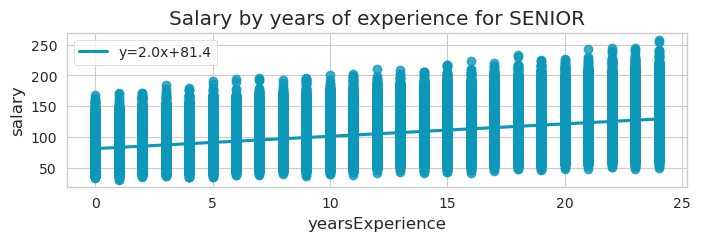

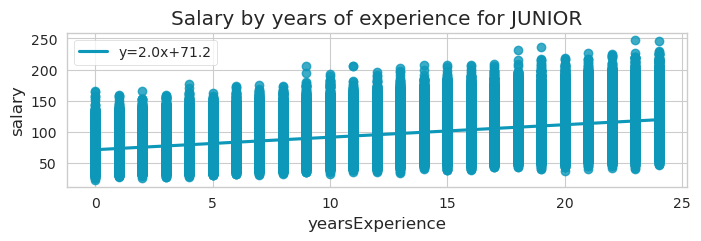

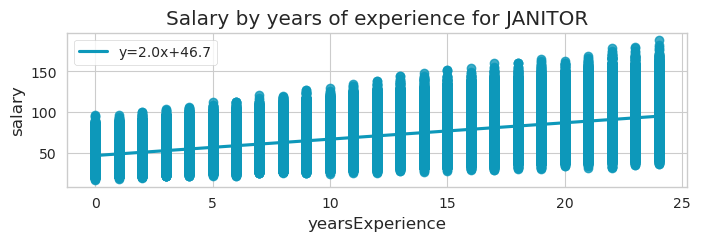

In [42]:
slope_list = []  # para salvar as inclinações das linhas de regressão
intercept_list = [] # para salvar as interceptações das linhas de regressão

for job in job_list:
    df_x = df_p.loc[df_p['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

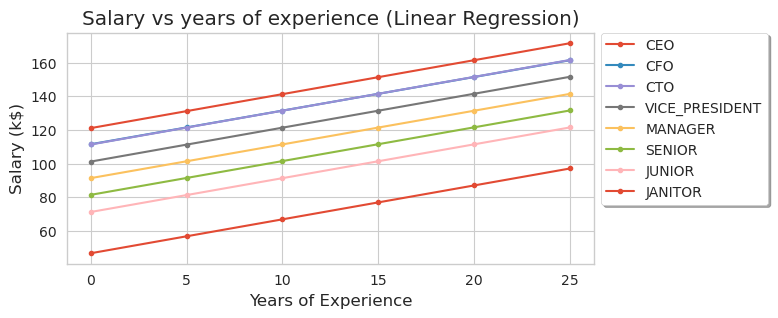

In [43]:
X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8,3))
for i in range(8):
    plt.plot(X, slope_list[i]*X+intercept_list[i],label=job_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
plt.ylabel('Salary (k$)')
plt.xlabel('Years of Experience')
plt.title('Salary vs years of experience (Linear Regression)')
plt.show()

**Podemos ver uma tendência crescente entre anos de experiência e salário entre todos os diferentes cargos: isso significa que mais anos de experiência levam a salários mais altos para todos os cargos.
Observando a inclinação e interceptação para cada modelo linear, podemos ver que a inclinação é arredondada para 2,0 para todos os cargos: isso significa que, em média, todos esses empregos têm um aumento de salário de 2000\\$ anualmente. A diferença é o intercepto, que pode ser interpretado como o salário médio de um trabalhador com 0 anos de experiência. Em particular, podemos ver um valor de interceptação de 121,5k\\$ para CEO e 46,7k\\$ para zelador.**

# Q6 Os trabalhadores com graus mais elevados têm empregos mais bem remunerados?

In [44]:
df_q6 = spark.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|       NONE|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



Podemos ver alguns valores NONE na coluna de grau: vamos descartar as linhas sem grau.

In [45]:
df_q6 = df_q6.replace('NONE',None)

In [46]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       null|    17|JANITOR|
|       null|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       null|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [47]:
df_q6 = df_q6.na.drop()

In [48]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



Então, como visto para Q5, vamos extrair uma lista de diferentes graus:

In [49]:
df_q6.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [50]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

Finalmente, podemos converter o dataframe extraído pela consulta SQL 'Q6' em um dataframe pandas para plotar o resultado desejado.

In [51]:
df_p = df_q6.toPandas()

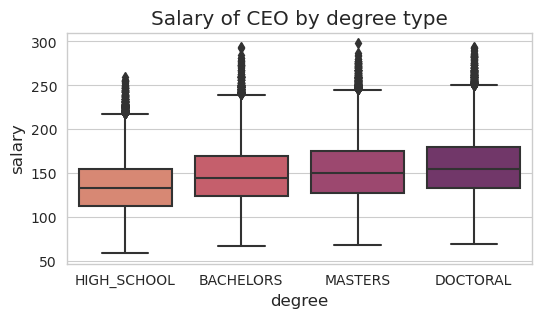

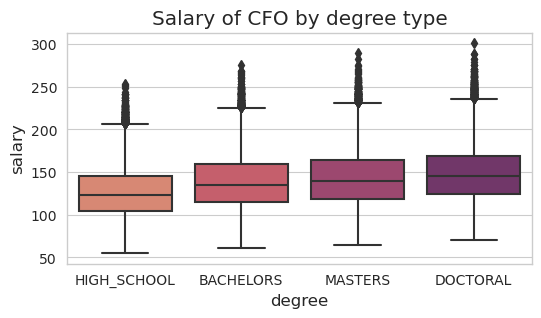

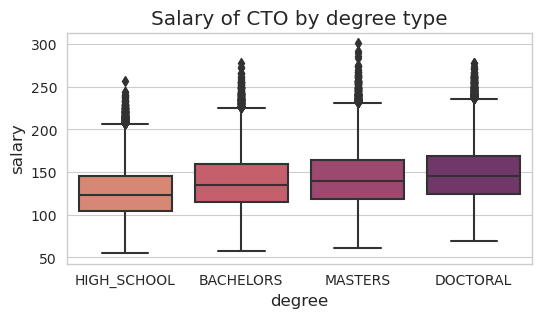

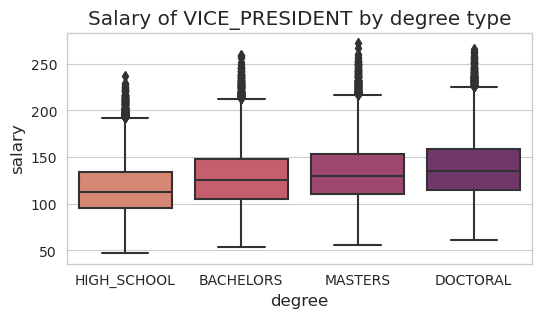

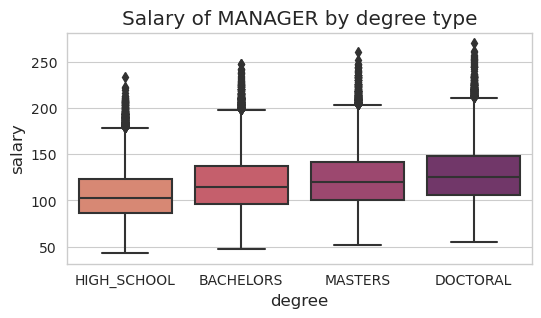

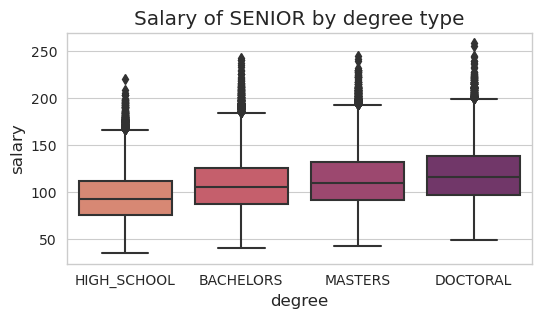

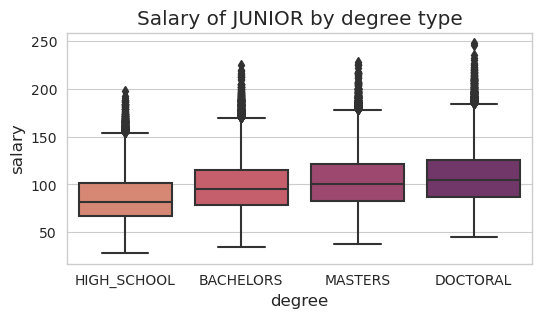

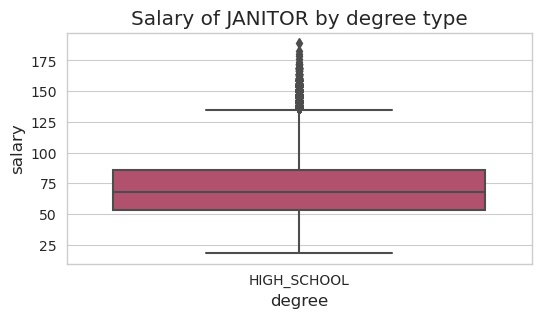

In [52]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(6,3))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

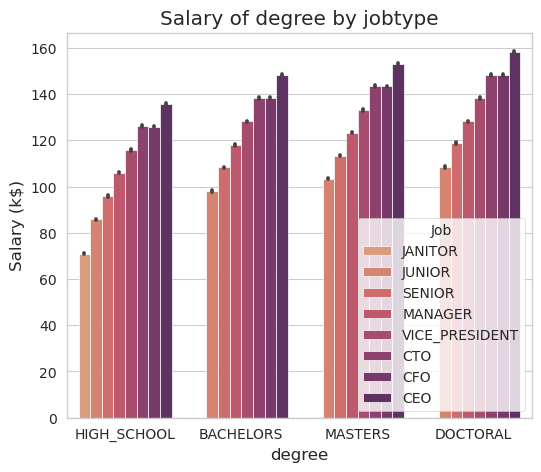

In [53]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

**Parece que para todos os tipos de trabalho neste conjunto de dados, os trabalhadores com nível superior recebem mais. Em particular, podemos ver uma diferença maior de salários entre 'ensino médio' e 'bacharel'.
Por fim, é interessante notar que no caso de zelador como tipo de trabalho, existem apenas pessoas com ensino médio.**

# Q7 O major afeta o salário?

In [54]:
df_q7 = spark.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



Ainda temos valores NONE em graduação e também em major (nota: se a graduação=High school, é claro que a major deve ser NONE!), iremos descartar esses valores!

In [55]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [56]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|       MATH|57800|
|    COMPSCI|58382|
| LITERATURE|58684|
+-----------+-----+



In [57]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



Neste dataframe não há JANITOR como um tipo de trabalho: isso significa que as pessoas com 'zelador' como um tipo de trabalho no conjunto de dados têm 'ensino médio' como graduação e, portanto, nenhuma especialização (conforme declarado na consulta anterior Q6). Precisamos definir uma nova lista de empregos sem zelador para os seguintes lotes!

In [58]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [59]:
df_p = df_q7.toPandas()

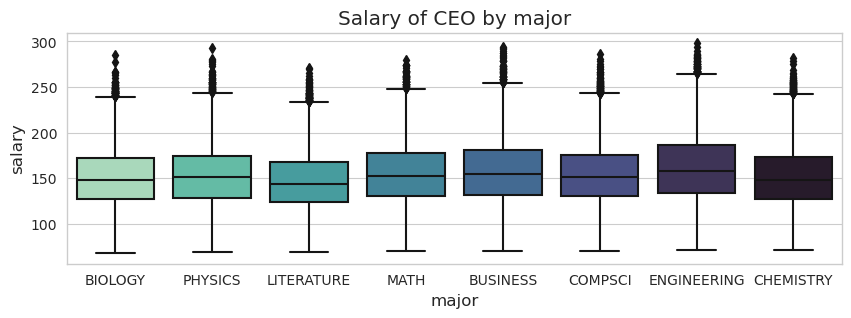

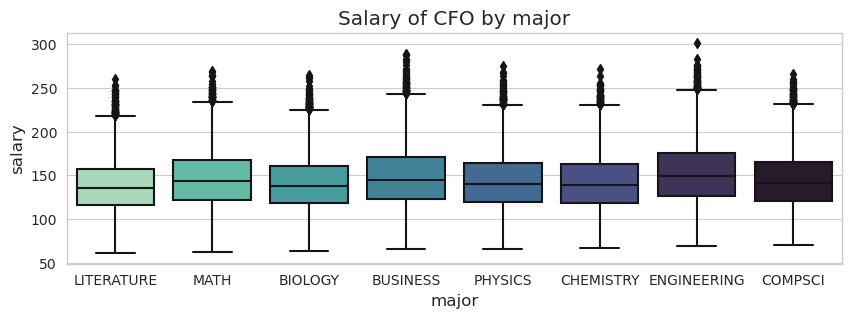

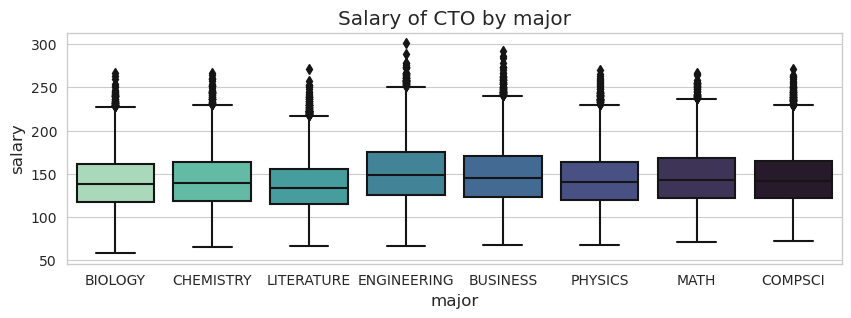

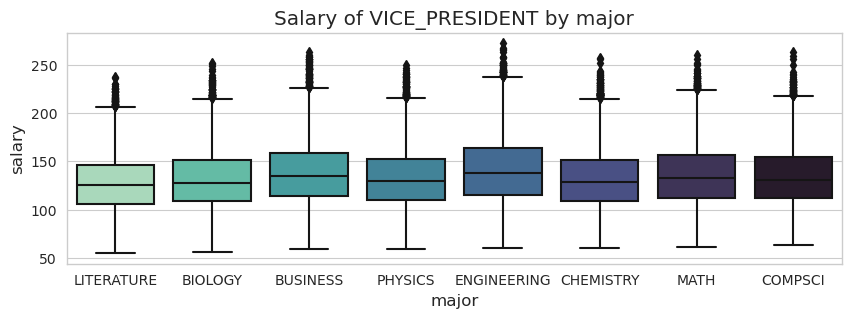

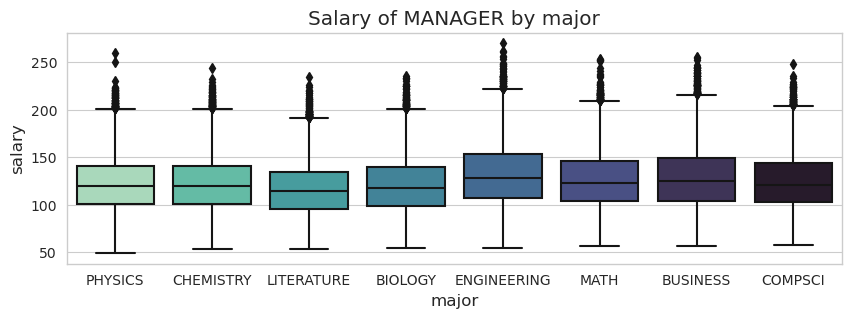

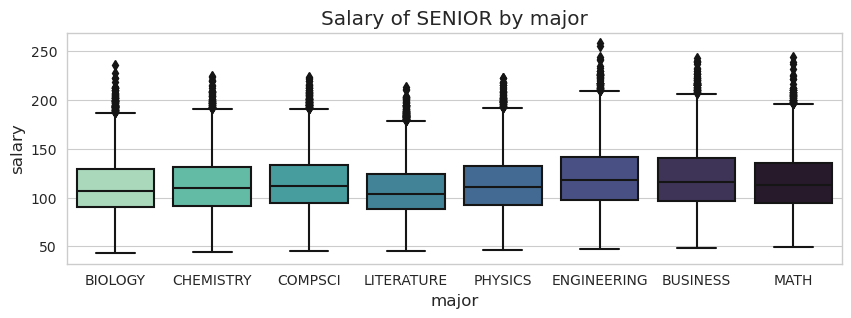

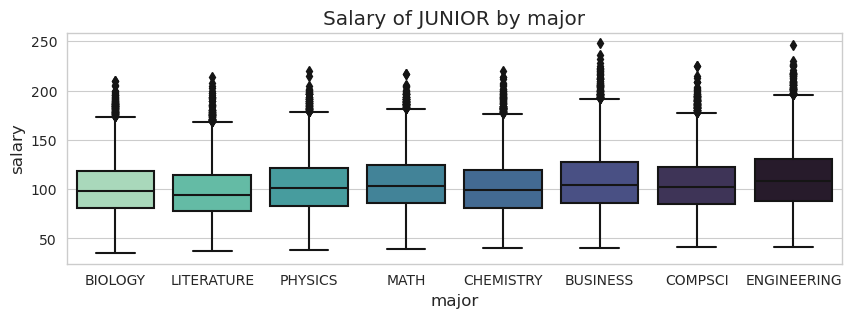

In [60]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

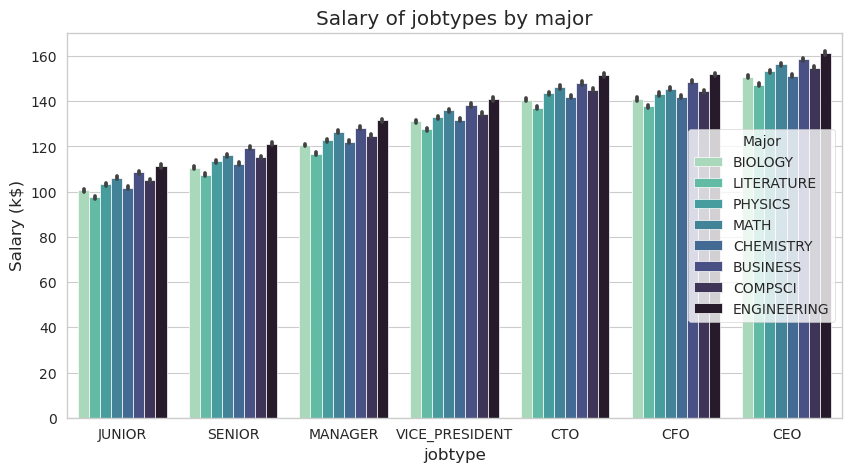

In [61]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

**Podemos ver que a engenharia é a principal dos trabalhadores com salários mais altos, o comércio é o segundo e enquanto a literatura é a principal dos trabalhadores com empregos de menor remuneração.**

# ML Modeling

Nesta seção, pré-processaremos os dados para treinamento de ML.

In [62]:
df.show(1)

+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|           jobId|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



Primeiro, criaremos uma cópia do dataframe chamada 'df_encoded', que incluirá os dados pré-processados.

In [63]:
df_encoded = df.alias('df_encoded')
id(df_encoded) == id(df)  # False

False

Removemos a coluna 'jobid', pois ela apenas identifica um trabalhador específico.

In [64]:
df_encoded = df_encoded.drop('jobId')

In [65]:
cols = df_encoded.columns

Além disso, pode ser interessante analisar a variável alvo 'salário':

In [66]:
salary_df = df_encoded.select('salary').toPandas()

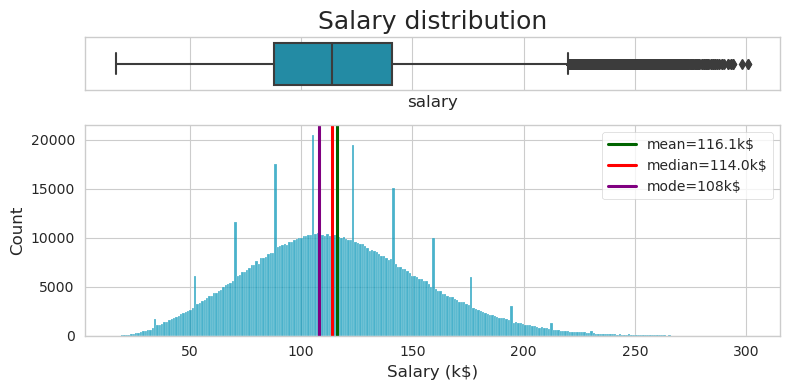

In [67]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Salary distribution',fontsize=18)
sns.boxplot(x='salary', data=salary_df, ax=ax[0], color='#0d98ba')
ax[0].set(yticks=[])
sns.histplot(x='salary', data=salary_df, ax=ax[1], color='#0d98ba')
plt.axvline(salary_df['salary'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(salary_df['salary'].mean(),1)) + 'k$')
plt.axvline(salary_df['salary'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(salary_df['salary'].median(),1)) + 'k$')
plt.axvline(salary_df['salary'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(salary_df['salary'].mode()[0]) + 'k$')
ax[1].set_xlabel('Salary (k$)')
plt.legend()
plt.tight_layout()
plt.show()

O recurso de salário tem uma distribuição de cauda longa assimétrica à direita, com alguns salários que aparecem várias vezes no conjunto de dados (os "picos" nestes histogramas).

## Label Encoding

Label encoding é um método ingênuo para codificar os recursos categóricos. A codificação de rótulos deve ser usada quando houver uma ordem entre as categorias.

In [68]:
categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Neste conjunto de dados, o único recurso categórico em que há uma hierarquia/ordem é grau, portanto, devemos codificar esse recurso com codificação de rótulo.

In [69]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

EDIT: melhoramos o R2 em 0,8% codificando 'grau' com codificação de rótulo em vez de uma codificação quente.

# One hot Encoding

Para executar uma codificação ativa no conjunto de dados, precisamos primeiro aplicar um indexador de string, conforme visto no codificador de rótulo, e depois fazer o codificador ativo real. Por fim, essas etapas serão adicionadas a uma variável "stages" e passadas a um objeto Pipeline.

In [70]:
categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [71]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [72]:
df_encoded.show(1)

+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|(86,[29,82,83,84,...|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



Podemos ver a presença de uma coluna de "recursos", incluindo todos os diferentes recursos codificados por uma codificação ativa e os recursos numéricos. Esta coluna 'recursos' e a coluna de destino 'salário' serão passadas para o algoritmo ML durante o treinamento.

## Train test split 

In [73]:
train, test = df_encoded.randomSplit([0.995, 0.005], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 994952 training examples and 5043 test examples.


# Gradient Boosting Trees

In [74]:
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [75]:
gbt_model = gbt.fit(train)

In [76]:
predictions = gbt_model.transform(test)

# Prediction results

In [78]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

19.23442536251691

In [79]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7508301758280195

In [80]:
rf_results = predictions.toPandas()

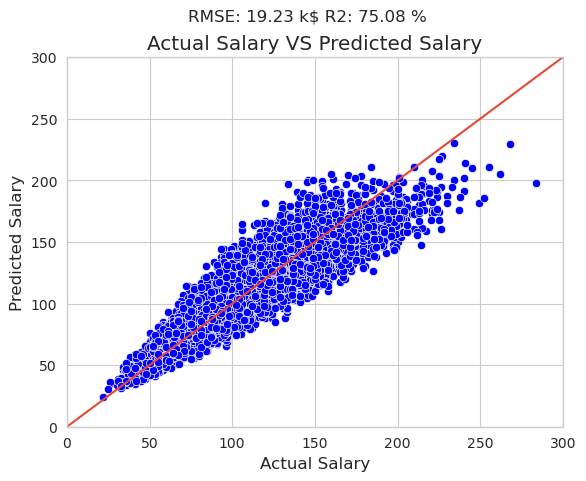

In [81]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [82]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.23 k$ 
R2: 75.08 %


Podemos ver que o algoritmo prevê melhores salários abaixo de 130k\\$, e começa a subestimar os salários acima de 175k\\$. Isso pode ser devido à assimetria correta da distribuição salarial.<br>
No geral, os resultados são satisfatórios em termos de RMSE e R2. Outras melhorias podem ser alcançadas por um ajuste adequado de hiperparâmetros e engenharia de recursos nos dados.

In [83]:
spark.stop()

**cezaraugustomeiracarmo@gmail.com - (Baseado em https://www.kaggle.com/code/ludovicocuoghi/pyspark-sql-queries-and-machine-learning/notebook).